# Length of stay summary dev - hillmaker (v0.5.0)

<div class="alert alert-block alert-warning">
    <b>WARNING</b> Numerous API and core code changes have happened to hillmaker recently and this notebook is specific to v0.5.x. 
</div>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from IPython.display import Image

import hillmaker as hm

In [3]:
ssu_stopdata = '../data/ShortStay.csv'
stops_df = pd.read_csv(ssu_stopdata, parse_dates=['InRoomTS','OutRoomTS'])
stops_df.info() # Check out the structure of the resulting DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59877 entries, 0 to 59876
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   PatID      59877 non-null  int64         
 1   InRoomTS   59877 non-null  datetime64[ns]
 2   OutRoomTS  59877 non-null  datetime64[ns]
 3   PatType    59877 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 1.8+ MB


In [4]:
stops_df.head()

,PatID,InRoomTS,OutRoomTS,PatType
0,1,1996-01-01 07:44:00,1996-01-01 08:50:00,IVT
1,2,1996-01-01 08:28:00,1996-01-01 09:20:00,IVT
2,3,1996-01-01 11:44:00,1996-01-01 13:30:00,MYE
3,4,1996-01-01 11:51:00,1996-01-01 12:55:00,CAT
4,5,1996-01-01 12:10:00,1996-01-01 13:00:00,IVT


## Length of stay summary

We can precompute LOS during the pydantic model pre-processing step. Instead of storing it as a Timedelta, we could allow user to specify units for LOS summary (default = 'h') where the unit string codes are same as used for Timedelta conversions.

https://en.wikipedia.org/wiki/ISO_8601#Durations

In [5]:
units = 'hours'

In [6]:
los_field_name = f'los_{units}'
stops_df[los_field_name] = (stops_df['OutRoomTS'] - stops_df['InRoomTS']) / pd.Timedelta(1, units)
stops_df.head()

,PatID,InRoomTS,OutRoomTS,PatType,los_hours
0,1,1996-01-01 07:44:00,1996-01-01 08:50:00,IVT,1.100000
1,2,1996-01-01 08:28:00,1996-01-01 09:20:00,IVT,0.866667
2,3,1996-01-01 11:44:00,1996-01-01 13:30:00,MYE,1.766667
3,4,1996-01-01 11:51:00,1996-01-01 12:55:00,CAT,1.066667
4,5,1996-01-01 12:10:00,1996-01-01 13:00:00,IVT,0.833333


In [7]:
stops_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59877 entries, 0 to 59876
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   PatID      59877 non-null  int64         
 1   InRoomTS   59877 non-null  datetime64[ns]
 2   OutRoomTS  59877 non-null  datetime64[ns]
 3   PatType    59877 non-null  object        
 4   los_hours  59877 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(1), object(1)
memory usage: 2.3+ MB


In addition to statistical summaries as shown below, it would be nice to have histograms.

In [8]:
stops_df.groupby(['PatType'])[los_field_name].describe()

,count,mean,std,min,25%,50%,75%,max
PatType,,,,,,,,
ART,5761.0,1.479483,0.375888,0.533333,1.183333,1.416667,1.75,2.483333
CAT,10692.0,1.043914,0.567298,0.066667,0.666667,0.983333,1.25,5.983333
IVT,33179.0,1.147418,0.702600,0.000000,0.733333,1.000000,1.40,10.916667
MYE,6478.0,1.429021,0.397153,0.533333,1.133333,1.366667,1.70,2.483333
OTH,3767.0,1.502048,0.349509,1.016667,1.200000,1.450000,1.75,2.483333


In [9]:
from pandas.core.groupby import DataFrameGroupBy
from typing import Dict, List, Tuple

In [10]:
def summary_stats(group: DataFrameGroupBy,
                  percentiles: Tuple[float] | List[float] = (0.25, 0.5, 0.75, 0.95, 0.99),
                  stub: str = ''):
    """
    Compute summary statistics on a pandas `DataFrameGroupBy` object.

    Parameters
    ----------
    group : pd.DataFrameGroupBy
        The grouping is by category
    percentiles : list or tuple of floats (e.g. [0.5, 0.75, 0.95]), optional
        Which percentiles to compute. Default is (0.25, 0.5, 0.75, 0.95, 0.99)
    stub : str
        Used to create field names (e.g. '{stub}_mean')

    Returns
    -------
    Dict whose keys are '{stub}_{statistic}'. Dict values are `DataFrame` objects.

    """
    stats = {stub + 'count': group.count(), stub + 'mean': group.mean(),
             stub + 'min': group.min(),
             stub + 'max': group.max(), 'stdev': group.std(), 'sem': group.sem(),
             stub + 'var': group.var(), 'cv': group.std() / group.mean() if group.mean() > 0 else 0,
             stub + 'skew': group.skew(), 'kurt': group.kurt()}

    if percentiles is not None:
        pctile_vals = group.quantile(percentiles)

        for p in percentiles:
            pctile_name = f'{stub}p{int(100 * p):d}'
            stats[pctile_name] = pctile_vals[p]

    return stats

In [11]:
cat_field_grp = stops_df.groupby(['PatType'])
occ_stats = cat_field_grp[los_field_name].apply(summary_stats).unstack()
occ_stats

,count,mean,min,max,stdev,sem,var,cv,skew,kurt,p25,p50,p75,p95,p99
PatType,,,,,,,,,,,,,,,
ART,5761.0,1.479483,0.533333,2.483333,0.375888,0.004952,0.141292,0.254067,0.388482,-0.506492,1.183333,1.416667,1.75,2.166667,2.350000
CAT,10692.0,1.043914,0.066667,5.983333,0.567298,0.005486,0.321827,0.543433,2.097465,8.190130,0.666667,0.983333,1.25,2.074167,3.150000
IVT,33179.0,1.147418,0.000000,10.916667,0.702600,0.003857,0.493647,0.612331,2.870813,16.362389,0.733333,1.000000,1.40,2.318333,3.833333
MYE,6478.0,1.429021,0.533333,2.483333,0.397153,0.004934,0.157731,0.277920,0.397701,-0.446451,1.133333,1.366667,1.70,2.166667,2.350000
OTH,3767.0,1.502048,1.016667,2.483333,0.349509,0.005695,0.122157,0.232688,0.532790,-0.652905,1.200000,1.450000,1.75,2.150000,2.316667


How to make nice looking tabular outputs? Similar to [gt](https://posit.co/blog/great-looking-tables-gt-0-2/) in R.

Use pandas Stylers - https://pandas.pydata.org/docs/user_guide/style.html

Also, do we really need Seaborn or can we make do with matplotlib? Seaborn has some nice built in plots. :)

In [16]:
cols = ['count', 'mean', 'min', 'max', 'stdev', 'cv', 'skew', 'p50', 'p75', 'p95', 'p99']
float_format = '{0:.1f}'
mapper =  {'count': '{:.0f}',
           'mean': float_format,
           'min': float_format,
           'max': float_format,
           'stdev': float_format,
           'cv': float_format,
           'skew': float_format,
           'p50': float_format,
           'p75': float_format,
           'p95': float_format,
           'p99': float_format}
occ_stats[cols].style.format(mapper)
#  .format(precision=1)

,count,mean,min,max,stdev,cv,skew,p50,p75,p95,p99
PatType,,,,,,,,,,,
ART,5761,1.5,0.5,2.5,0.4,0.3,0.4,1.4,1.8,2.2,2.4
CAT,10692,1.0,0.1,6.0,0.6,0.5,2.1,1.0,1.2,2.1,3.1
IVT,33179,1.1,0.0,10.9,0.7,0.6,2.9,1.0,1.4,2.3,3.8
MYE,6478,1.4,0.5,2.5,0.4,0.3,0.4,1.4,1.7,2.2,2.4
OTH,3767,1.5,1.0,2.5,0.3,0.2,0.5,1.4,1.8,2.1,2.3


In [18]:
# Import seaborn
import seaborn as sns

# Apply the default theme
sns.set_theme()

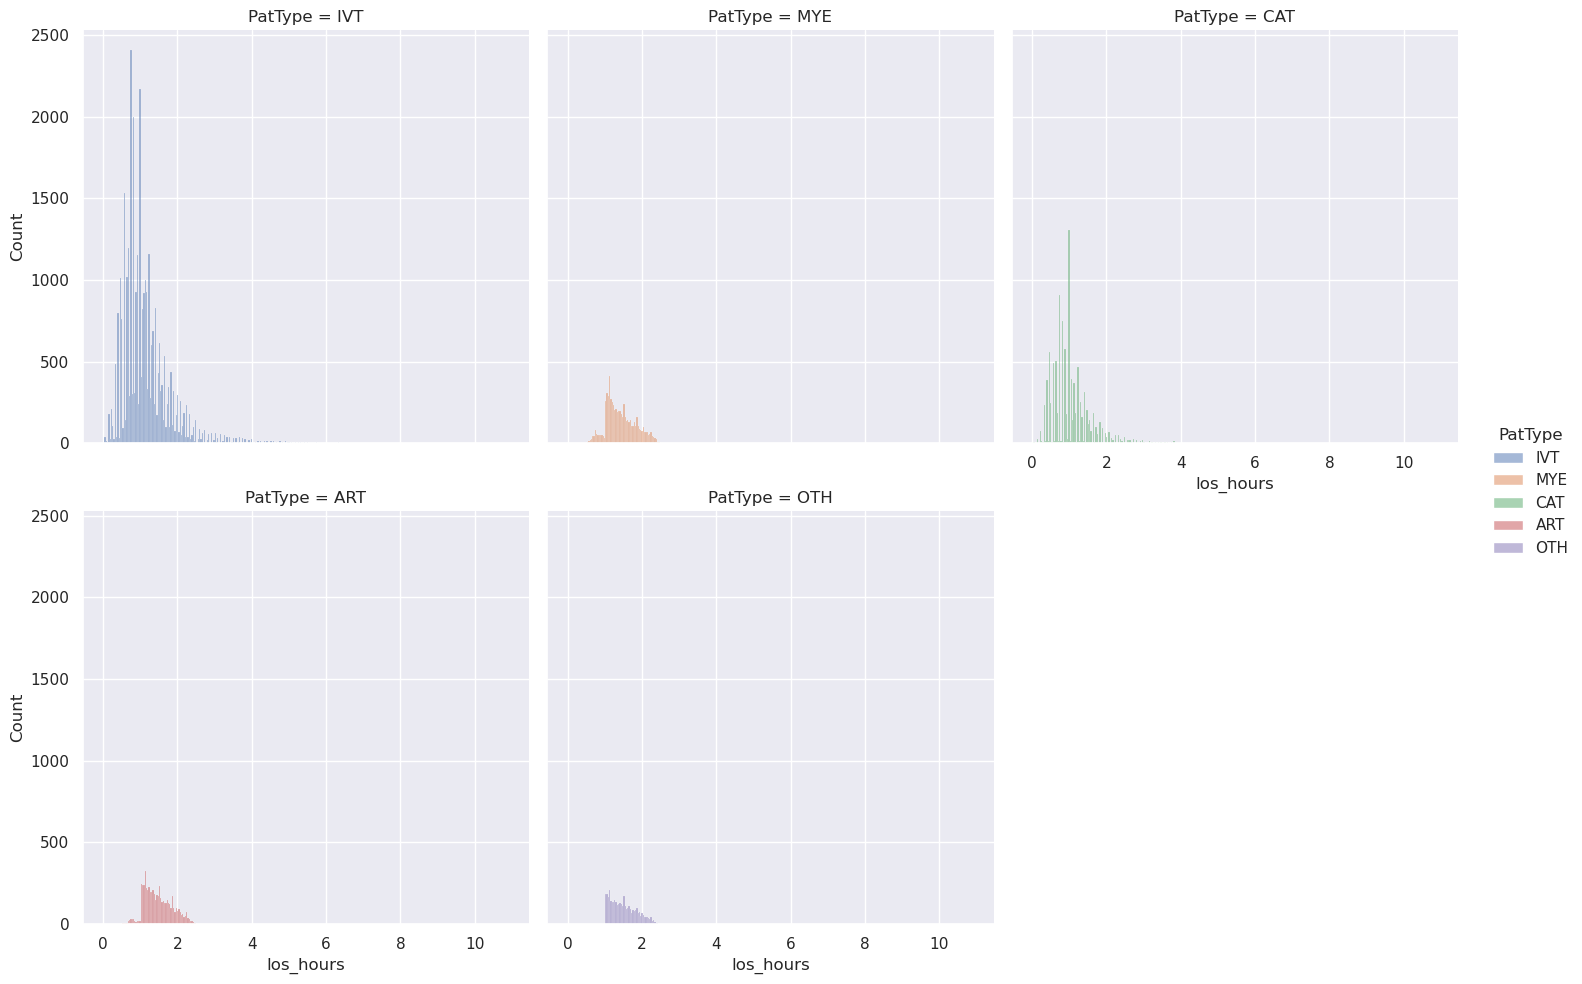

In [19]:
sns.displot(data=stops_df, x="los_hours", hue="PatType", col="PatType", col_wrap=3)

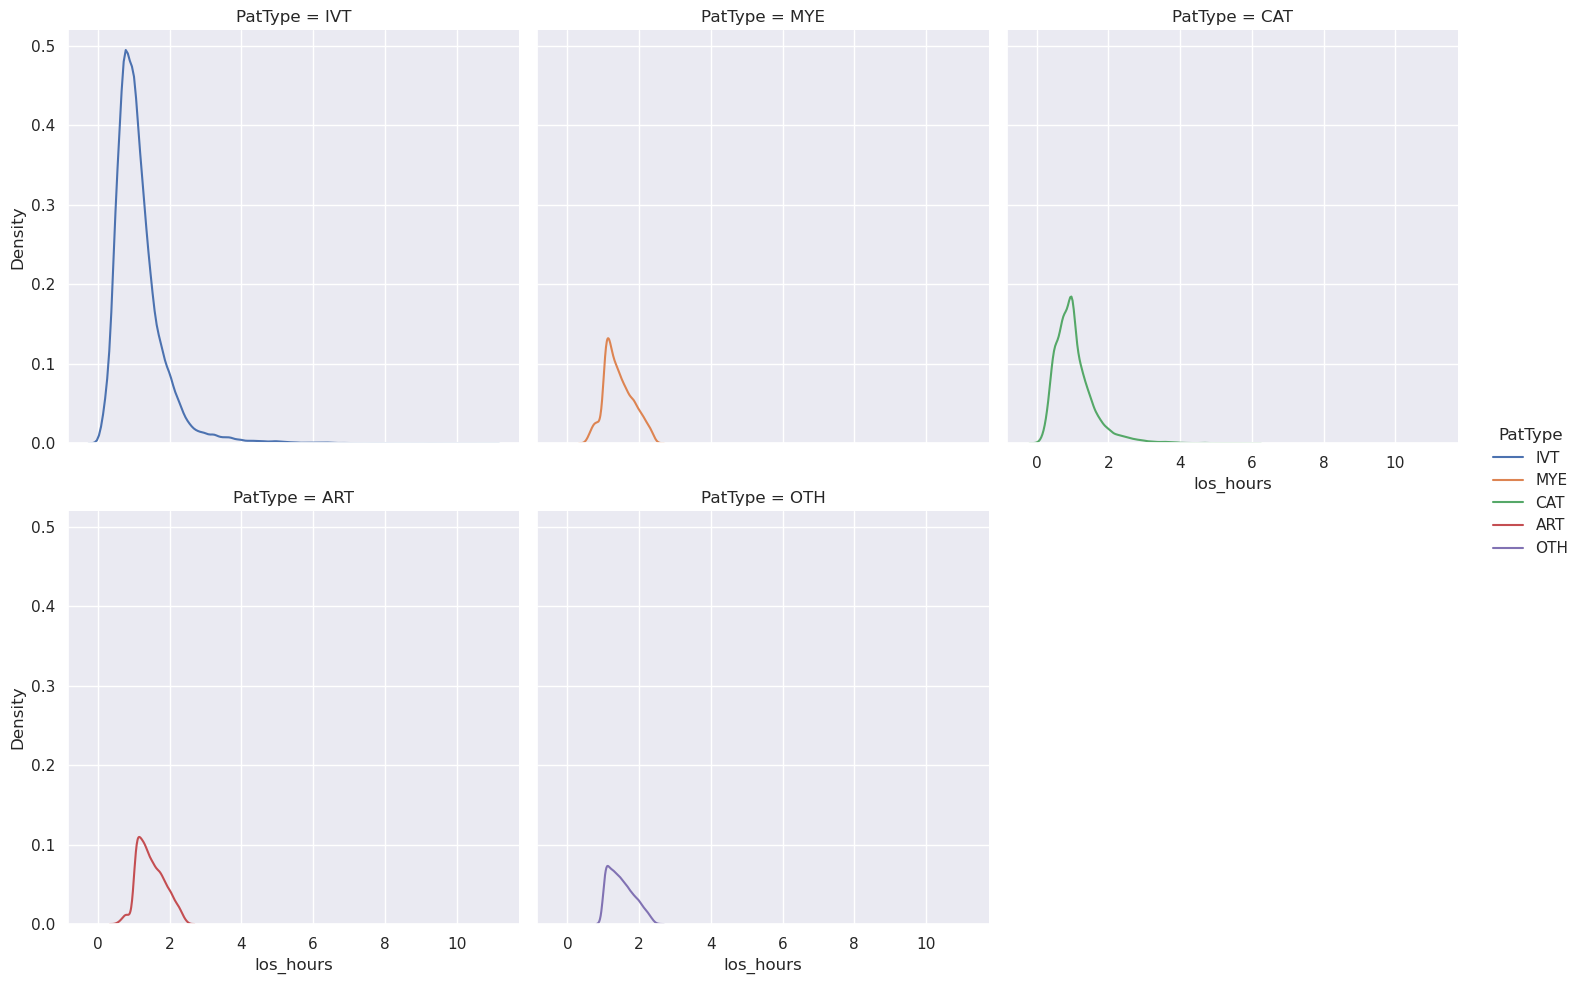

In [20]:
sns.displot(data=stops_df, x="los_hours", hue="PatType", col="PatType", kind='kde', col_wrap=3)

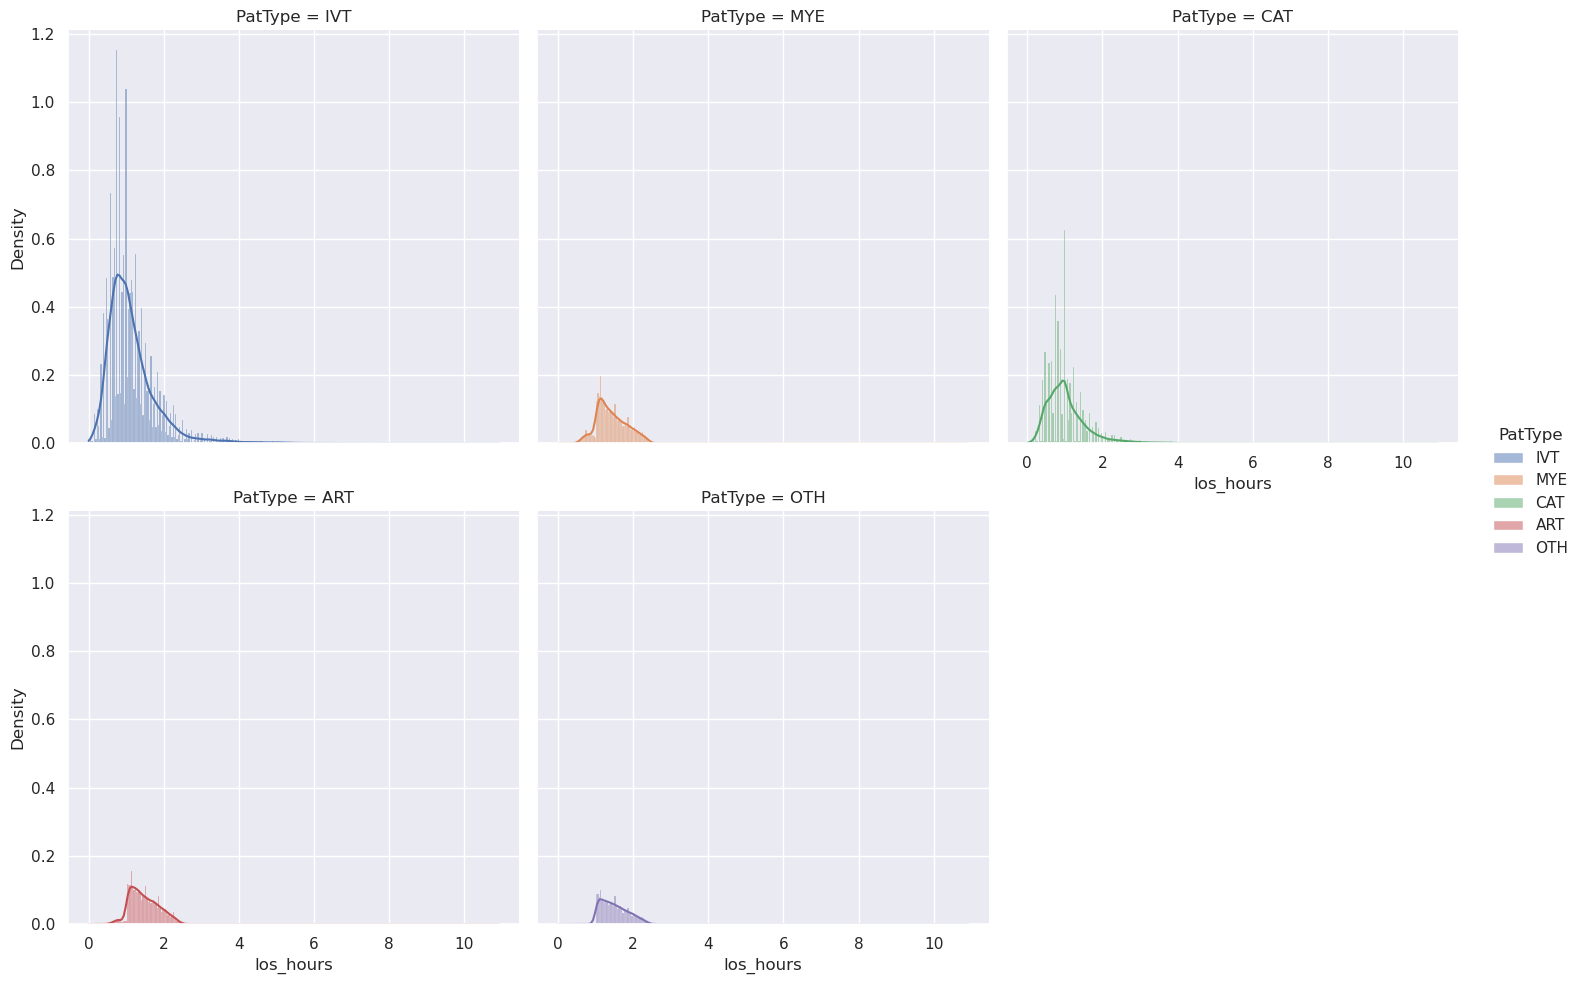

In [21]:
sns.displot(data=stops_df, x="los_hours", hue="PatType", col="PatType", stat='density', kde=True, col_wrap=3)

I think to have a non-shared y-axis, you have to use the `FacetGrid` and `map` approach.

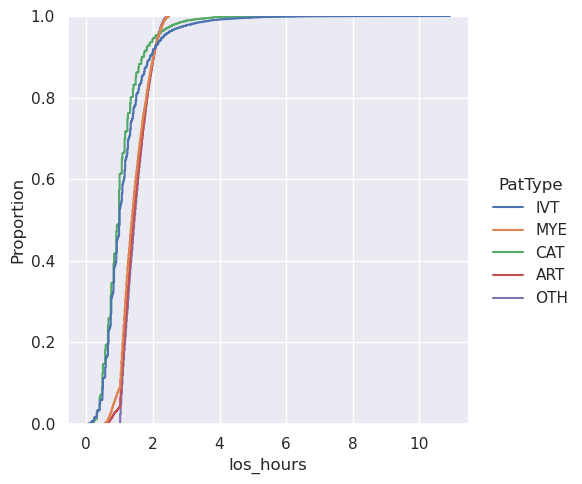

In [16]:
sns.displot(data=stops_df, x="los_hours", hue="PatType", kind='ecdf')

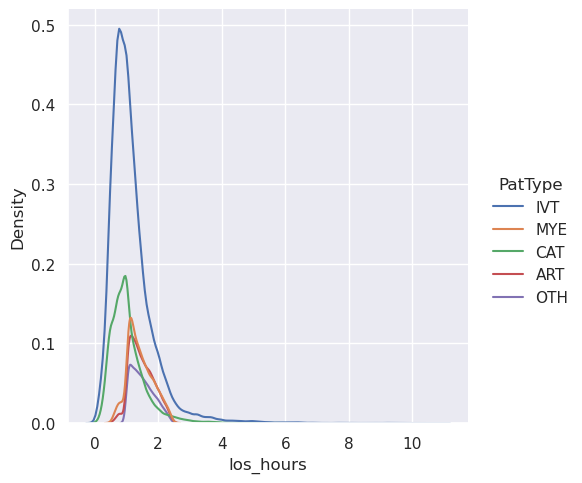

In [17]:
sns.displot(data=stops_df, x="los_hours", hue="PatType", kind='kde')

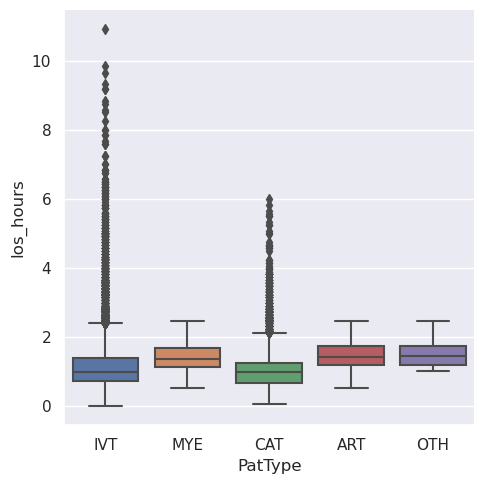

In [18]:
sns.catplot(data=stops_df, x="PatType", y="los_hours", kind="box")

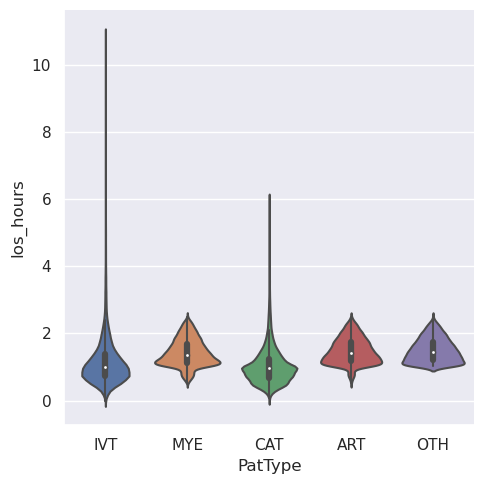

In [19]:
sns.catplot(data=stops_df, x="PatType", y="los_hours", kind="violin")

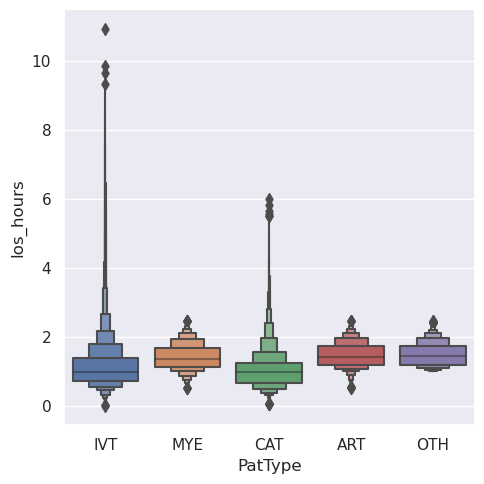

In [20]:
sns.catplot(data=stops_df, x="PatType", y="los_hours", kind="boxen")

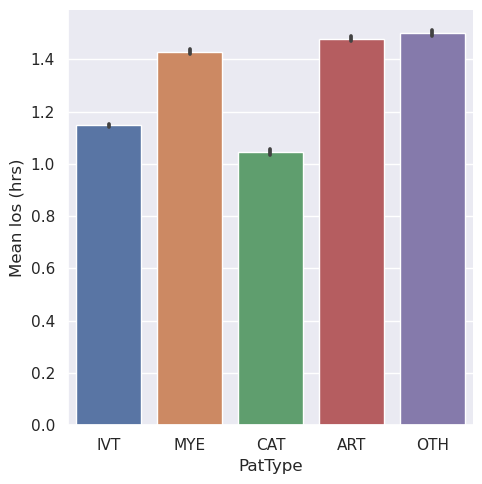

In [30]:
mean_los_plot = sns.catplot(data=stops_df, x="PatType", y="los_hours", kind="bar")
# https://stackoverflow.com/questions/43920341/facetgrid-change-titles
axes = mean_los_plot.axes.flatten()
axes[0].set_ylabel("Mean los (hrs)")
mean_los_plot

Need to change y-axis to be relative frequency instead of raw counts.

In [ ]:
sns.displot(data=stops_df, x="los_hours", hue="PatType", element="step")

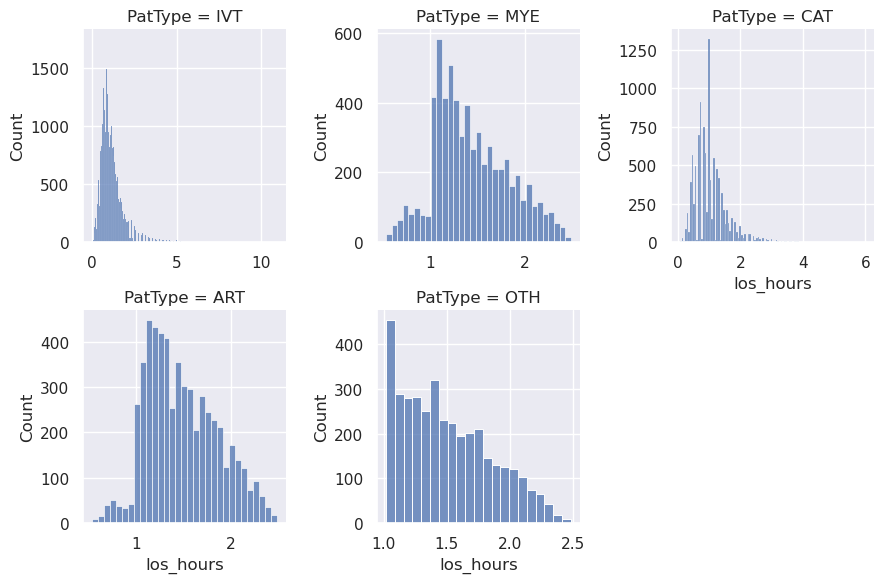

In [23]:
g = sns.FacetGrid(data=stops_df, col="PatType", sharex=False, sharey=False, col_wrap=3)
g.map(sns.histplot, "los_hours")

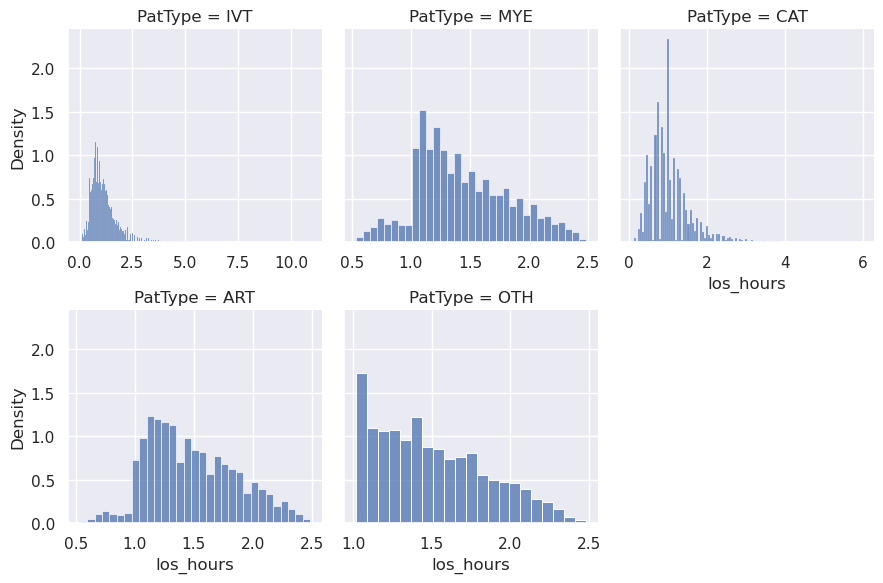

In [24]:
g = sns.FacetGrid(data=stops_df, col="PatType", sharex=False, col_wrap=3);
g.map(sns.histplot, "los_hours", stat='density');

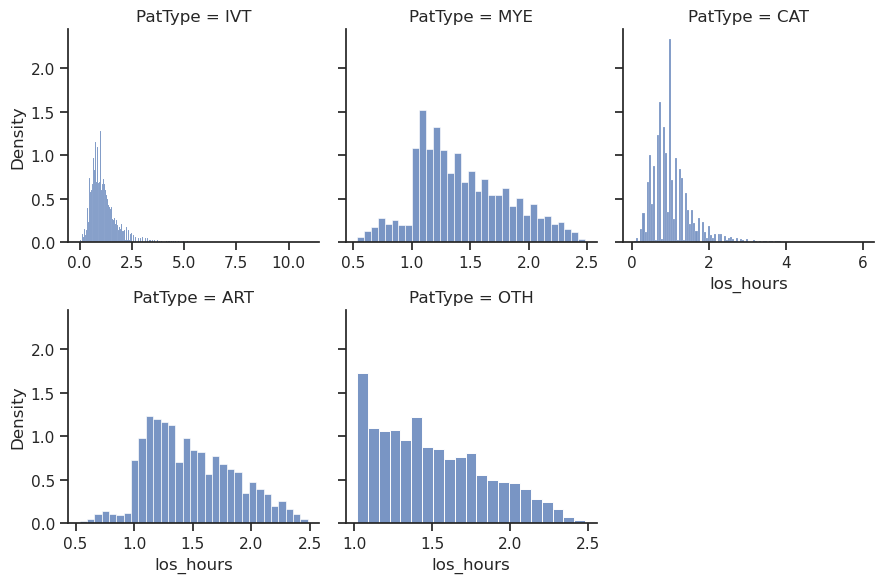

In [26]:
sns.set_style('ticks')
g = sns.FacetGrid(data=stops_df, col="PatType", sharex=False, col_wrap=3);
g.map(sns.histplot, "los_hours", stat='density', common_norm=False);

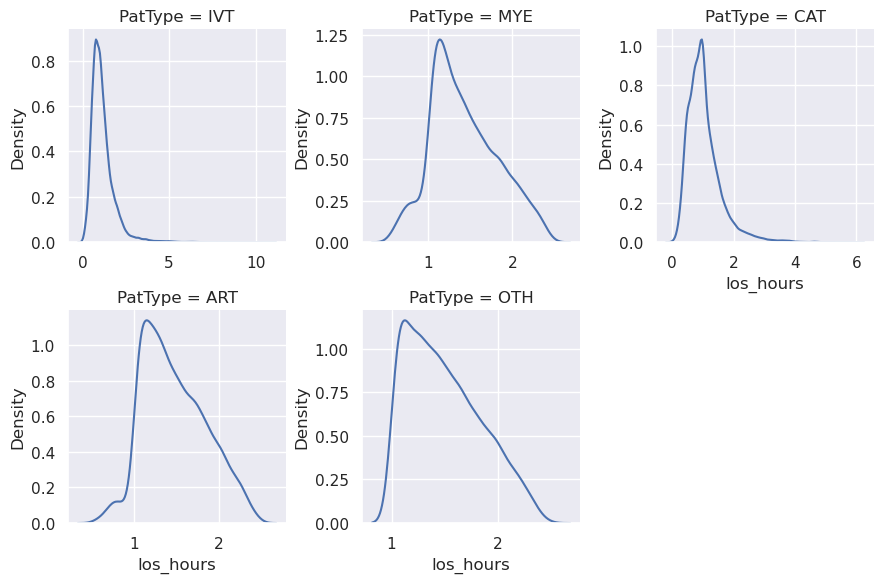

In [25]:
g = sns.FacetGrid(data=stops_df, col="PatType", sharex=False, sharey=False, col_wrap=3);
g.map(sns.kdeplot, "los_hours");